In [1]:
from glob import glob
import numpy as np
import pandas as pd
import keras
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.models import Model, Sequential
from matplotlib import pyplot as plt
from sklearn.svm import LinearSVC

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [3]:
WINDOW_SIZE = 60 * 4
TP_RANGE = 60
FP_RANGE = 60
DYNAMIC_FAULTS = ["node-drain", "pod-autoscaler", "pod-delete"]
STATIC_FAULTS = ["node-cpu-hog", "node-memory-hog", "pod-cpu-hog", "pod-memory-hog", "pod-network-latency"]
NODE_FAULTS = ["node-cpu-hog", "node-memory-hog", "node-drain"]

In [4]:
data = list(glob("../data/**/features/baseline.pickle"))

In [5]:
df = pd.DataFrame()
for file in data:
    df = pd.concat([df, pd.read_pickle(file)])

df["request_count"] = df["request_count"].astype(float)
df["request_count_5xx"] = df["request_count_5xx"].astype(float)

df = df[~df.index.duplicated(keep=False)]

df.fillna(0, inplace=True)

print(df.shape)

(28797, 10)


In [6]:
df.head()

,request_count,request_count_5xx,request_duration_min,request_duration_max,request_duration_average,request_duration_percentile_50.0,request_duration_percentile_90.0,request_duration_percentile_95.0,request_duration_deviation,request_duration_variance
2024-02-10 00:00:00,1.820833,0.0,39.772159,49.25903,45.698252,47.020918,49.259030,49.25903,3.569976,12.744728
2024-02-10 00:00:15,1.820833,0.0,39.772159,49.25903,45.268654,47.020918,49.259030,49.25903,3.711632,13.776211
2024-02-10 00:00:30,1.716667,0.0,39.772159,49.25903,44.863246,47.020918,49.259030,49.25903,3.768974,14.205166
2024-02-10 00:00:45,1.716667,0.0,39.772159,49.25903,44.435679,47.020918,49.259030,49.25903,3.755323,14.102454
2024-02-10 00:01:00,1.716667,0.0,39.772159,49.25903,44.008111,41.592227,47.817676,49.25903,3.692440,13.634114


In [7]:
# df = df.between_time("06:45:00", "01:15:00")

In [8]:
labels = pd.read_csv("../data/labels.csv")

In [9]:
labels["experiment_created_at"] = pd.to_datetime(labels["experiment_created_at"])
labels["experiment_started_at"] = pd.to_datetime(labels["experiment_started_at"])
labels["experiment_finished_at"] = pd.to_datetime(labels["experiment_finished_at"])

labels["fault_started_at"] = pd.to_datetime(labels["fault_started_at"])
labels["fault_finished_at"] = pd.to_datetime(labels["fault_finished_at"])

anomalies = pd.DataFrame()
for idx, row in labels.iterrows():
    if not pd.isna(row["fault_started_at"]):
        anomalies = pd.concat([anomalies, df.iloc[df.index.get_indexer([row['fault_started_at']], method='nearest')]])
    else:
        anomalies = pd.concat([anomalies, df.iloc[df.index.get_indexer([row['experiment_started_at']], method='nearest')]])

In [10]:
y = pd.Series([0 if idx not in anomalies.index else 1 for idx, row in df.iterrows()], index=df.index)
print(y.shape)

(28797,)


In [11]:
print(f"Samples: {y.shape}")
print(f"Healthy: {y[y == 0].shape}")
print(f"Anomalous: {y[y == 1].shape}")

Samples: (28797,)
Healthy: (28756,)
Anomalous: (41,)


### Split data

In [12]:
X = keras.utils.normalize(df.values, axis=0, order=2)

In [13]:
def temporalize(X, y, window_size=5):

    output_X = []
    output_y = []
    for i in range(len(X) - window_size):
        output_X.append(X[i:i + window_size])
        output_y.append(y[i + window_size])

    return np.array(output_X), np.array(output_y)

In [14]:
X, y = temporalize(X, y, window_size=WINDOW_SIZE)

### Split data

In [15]:
# X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
#
# # Split healthy and anomalous examples for training
# Y_train = list(map(bool, Y_train))
# Y_test = list(map(bool, Y_test))
#
# X_train_normal = X_train[Y_train]
# X_test_normal = X_test[Y_test]
#
# X_train_anomaly = X_train[Y_train]
# X_test_anomaly = X_test[Y_test]

In [16]:
def idx_to_timestamp(idx_):
    return df.index[idx_]

def timestamp_to_idx(timestamp_):
    return df.index.get_slice_bound(timestamp_, "right")

In [17]:
X_train = np.array([x for idx, x in enumerate(X) if idx_to_timestamp(idx) >= pd.Timestamp("2024-02-10 16:47:02") and idx_to_timestamp(idx) <= pd.Timestamp("2024-02-11 10:00:00")])
Y_train = np.array([y for idx, y in enumerate(y) if idx_to_timestamp(idx) >= pd.Timestamp("2024-02-10 16:47:02") and idx_to_timestamp(idx) <= pd.Timestamp("2024-02-11 10:00:00")])

X_val = np.array([x for idx, x in enumerate(X) if idx_to_timestamp(idx) > pd.Timestamp("2024-02-11 10:00:00") and idx_to_timestamp(idx) < pd.Timestamp("2024-02-13 06:00:00")])
Y_val = np.array([y for idx, y in enumerate(y) if idx_to_timestamp(idx) > pd.Timestamp("2024-02-11 10:00:00") and idx_to_timestamp(idx) < pd.Timestamp("2024-02-13 06:00:00")])
Y_val_ranges = []
for idx, label in enumerate(Y_val):
    if label == 1:
        Y_val_ranges.append((idx-TP_RANGE, idx+TP_RANGE))

X_test = np.array([x for idx, x in enumerate(X) if idx_to_timestamp(idx) >= pd.Timestamp("2024-02-13 06:00:00")])
Y_test = np.array([y for idx, y in enumerate(y) if idx_to_timestamp(idx) >= pd.Timestamp("2024-02-13 06:00:00")])
Y_test_ranges = []
for idx, label in enumerate(Y_test):
    if label == 1:
        Y_test_ranges.append((idx-TP_RANGE, idx+TP_RANGE))

In [18]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(4131, 240, 10)
(10557, 240, 10)
(9840, 240, 10)


In [19]:
class LSTMAutoEncoder(Model):
    def __init__(self):
        super(LSTMAutoEncoder, self).__init__()
        self.encoder = Sequential([
            LSTM(512, activation="relu", input_shape=(WINDOW_SIZE, df.shape[1]), return_sequences=True),
            LSTM(256, activation="relu", return_sequences=True),
            LSTM(64, activation="relu", return_sequences=False),
            RepeatVector(WINDOW_SIZE),
        ])

        self.decoder = Sequential([
            LSTM(64, activation="relu", return_sequences=True),
            LSTM(256, activation="relu", return_sequences=True),
            LSTM(512, activation="relu", return_sequences=True),
            TimeDistributed(Dense(df.shape[1]))
        ])

    def call(self, inputs, training=None, mask=None):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

In [20]:
# Create the model
model = LSTMAutoEncoder()
model.compile(optimizer='adam', loss='mae')

In [21]:
print(X_train.shape)

(4131, 240, 10)


In [22]:
# Train the model
model.fit(X_train, X_train, epochs=20, shuffle=False)

Epoch 1/20

130/130 [==============================] - 387s 3s/step - loss: 8.2277e-04
Epoch 2/20
130/130 [==============================] - 404s 3s/step - loss: 6.9439e-04
Epoch 3/20
130/130 [==============================] - 403s 3s/step - loss: 6.5778e-04
Epoch 4/20
130/130 [==============================] - 408s 3s/step - loss: 6.7858e-04
Epoch 5/20
130/130 [==============================] - 403s 3s/step - loss: 6.6366e-04
Epoch 6/20
130/130 [==============================] - 406s 3s/step - loss: 6.7914e-04
Epoch 7/20
130/130 [==============================] - 391s 3s/step - loss: 6.7969e-04
Epoch 8/20
130/130 [==============================] - 394s 3s/step - loss: 6.6002e-04
Epoch 9/20
130/130 [==============================] - 399s 3s/step - loss: 6.6634e-04
Epoch 10/20
130/130 [==============================] - 399s 3s/step - loss: 6.5357e-04
Epoch 11/20
130/130 [==============================] - 385s 3s/step - loss: 6.8042e-04
Epoch 12/20
130/130 [==============================

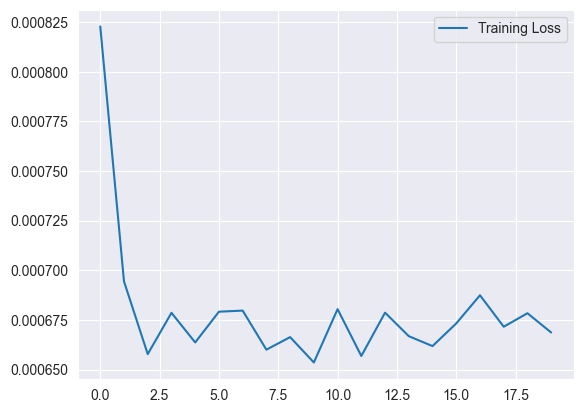

In [23]:
plt.plot(model.history.history["loss"], label="Training Loss")
plt.legend()

plt.show()

In [24]:
# Reconstruction of train data (healthy)
reconstructions = model.predict(X_train)

130/130 [==============================] - 64s 482ms/step


In [25]:
X_val.shape

(10557, 240, 10)

330/330 [==============================] - 156s 474ms/step


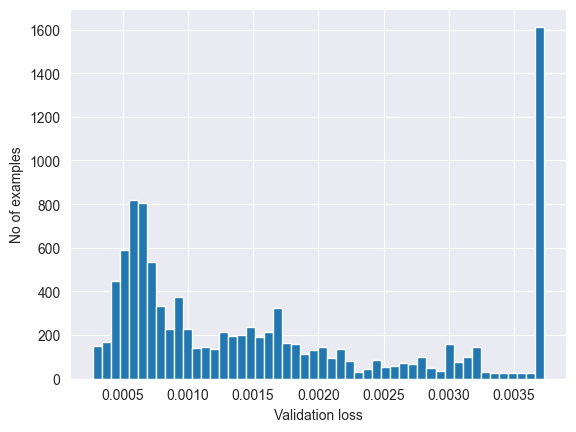

In [26]:
# Reconstruction of validation data
reconstructions = model.predict(X_val)
val_loss = np.array(keras.losses.mae(reconstructions, X_val))
val_loss = val_loss.mean(axis=1)

plt.hist(val_loss, bins=50)
plt.xlabel("Validation loss")
plt.ylabel("No of examples")
plt.show()

In [27]:
threshold = np.mean(val_loss) + np.std(val_loss)
print("Threshold: ", threshold)

Threshold:  0.0028216919262960887


In [28]:
Y_val_ = []
for i, _ in enumerate(Y_val):
    anomalous = False
    for idx1, idx2 in Y_val_ranges:
        if idx1 <= i <= idx2:
            anomalous = True
    Y_val_.append(anomalous)

svm_x = np.array(val_loss).reshape(-1, 1)
svm_y = np.array(Y_val_)
svm = LinearSVC(dual="auto", max_iter=10000, tol=1e-3, class_weight="balanced", loss="hinge")
svm.fit(svm_x, svm_y)

LinearSVC(class_weight='balanced', dual='auto', loss='hinge', max_iter=10000,
          tol=0.001)

In [29]:
# threshold = 0.0025

In [30]:
# Detect anomalies
results = model.predict(X_test)
test_loss = np.array(keras.losses.mae(results, X_test))
test_loss = test_loss.mean(axis=1)

308/308 [==============================] - 142s 462ms/step


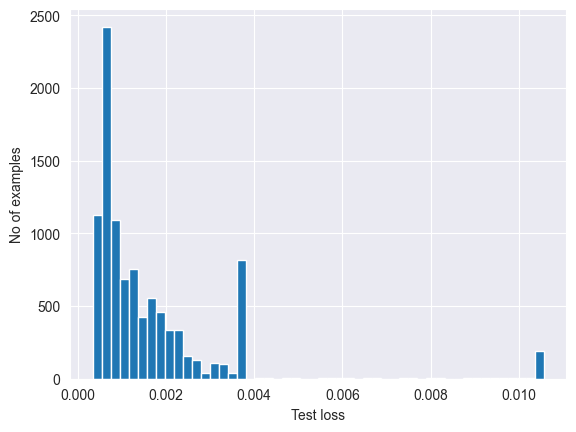

In [31]:
plt.hist(test_loss, bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [32]:
preds = [loss > threshold for loss in test_loss]

In [33]:
# preds = svm.predict(np.array(test_loss).reshape(-1, 1))

In [34]:
def evaluate(true_regions, predicted_timestamps, false_pos_region_delta=None):
    true_positives = 0
    false_positives = 0
    total_positives = 0

    found_true_positive = set()
    found_false_positive = set()
    # Iterate over each predicted timestamp
    for timestamp in predicted_timestamps:
        timestamp_found = False
        # Iterate over each true window
        for true_start, true_end in true_regions:
            # Check if the predicted timestamp falls within the current true window
            if true_start <= timestamp <= true_end:
                # If it falls within the window and a true positive within the window was already found ,
                # just continue, this are predictions related and close to eachother
                if (true_start, true_end) in found_true_positive:
                    timestamp_found = True
                    break
                # If it falls within the window and a true positive within the window is not found yet,
                # count it as a true positive and set the flag to True
                true_positives += 1
                found_true_positive.add((true_start, true_end))
                timestamp_found=True
                break
        # If the predicted timestamp falls outside the window, count it as a false positive
        if not timestamp_found:
            # but check if a previous false positive was within the range of an already detected false positive
            in_region = False
            for region in found_false_positive:
                if region[0] <= timestamp <= region[1]:
                    #if so, we just neglect it
                    in_region = True
                    break
            if not in_region:
                # otherwise, we add it, together with its range
                false_positives += 1
                if false_pos_region_delta is not None:
                    found_false_positive.add((timestamp, timestamp+false_pos_region_delta))


    # Calculate total number of true positives
    total_positives = len(true_regions)
    # Calculate precision and recall
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) != 0 else 0
    recall = true_positives / total_positives if total_positives != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    return precision, recall, f1

In [35]:
prec, recall, f1 = evaluate(Y_test_ranges, [idx for idx, p in enumerate(preds) if p], false_pos_region_delta=FP_RANGE)

In [36]:
print(f"Precision: {prec}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

Precision: 0.17391304347826086
Recall: 0.2
F1: 0.18604651162790697


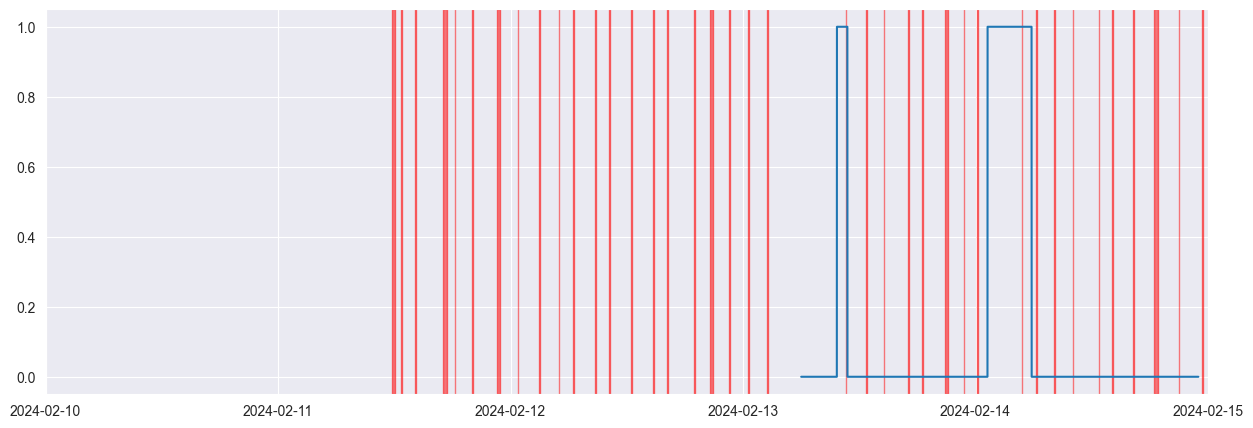

In [37]:
plt.figure(figsize=(15,5))
pred, = plt.plot([idx_to_timestamp((len(X) - len(Y_train) - len(Y_val) - len(Y_test)) + len(Y_train) + len(Y_val) + idx) for idx, _ in enumerate(preds)], preds, label="Predictions")
plt.gca().set_xlim((df.index[0], df.index[-1]))

dynamic_ = []
static_ = []
for i, row in labels.iterrows():
    # plt.axvline(x=row["fault_started_at"], color="green", linestyle="--", label="Vertical Line")
    # plt.axvline(x=row["fault_finished_at"], color="red", linestyle="--", label="Vertical Line")
    # plt.axvspan(row["fault_started_at"], row["fault_finished_at"], color="green", alpha=0.5)
    if not pd.isna(row["fault_started_at"]):
        ax = plt.axvspan(row["fault_started_at"], row["fault_finished_at"], color="red", alpha=0.5, label="Static Fault")

plt.show()